# Adaptive PDE discretizations on cartesian grids
## Volume : Algorithmic tools
## Part : Tensor decomposition techniques
## Chapter : Selling's algorithm, in dimension 2 and 3

This notebook presents some tensor decomposition techniques that are at the foundation of our anisotropic PDE discretizations on cartesian grids. The general objective is to write a given symmetric positive definite matrix $D$ under the form
$$
    D = \sum_{0 \leq i < I} \lambda_i e_i e_i^T. 
$$
From this point, various numerical schemes can be designed, for both first order and second order, and both linear and non-linear PDEs.

The techniques used for constructing the above decomposition are non-trivial, and are related to classical yet subtle tools of discrete geometry. This notebook is meant to illustrate some of their properties.

This notebook is limited to dimensions $d\in \{2,3\}$. Tensor decomposition in dimension $d \in \{4,5\}$ requires another set of techniques (and in practice the call to a c++ library), which are discussed in [II Tensor decomposition, dimensions 4 and 5](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorVoronoi.ipynb)

**References**

The tensor decomposition presented in this notebook is a central ingredient of the following paper:

Fehrenbach, J., & Mirebeau, J.-M. (2014). Sparse non-negative stencils for anisotropic diffusion. Journal of Mathematical Imaging and Vision, 49(1), 123–147. http://doi.org/http://dx.doi.org/10.1007/s10851-013-0446-3


[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Decomposing a tensor, or a tensor field](#1.-Decomposing-a-tensor,-or-a-tensor-field)
    * [1.1 Case of a $2\times 2$ matrix](#1.1-Case-of-a-$2\times-2$-matrix)
    * [1.2 Case of a $3 \times 3$ matrix.](#1.2-Case-of-a-$3-\times-3$-matrix.)
    * [1.3 Case of (extremely) strong anisotropy](#1.3-Case-of-(extremely)-strong-anisotropy)
    * [1.4 Decomposition a field of symmetric tensors](#1.4-Decomposition-a-field-of-symmetric-tensors)
  * [2. Under the hood : obtuse superbases](#2.-Under-the-hood-:-obtuse-superbases)
    * [2.1 Two dimensions](#2.1-Two-dimensions)
    * [2.2 Three dimensions](#2.2-Three-dimensions)
  * [3. Properties of the decomposition](#3.-Properties-of-the-decomposition)
    * [3.1 Offsets smallness](#3.1-Offsets-smallness)
    * [3.2 Stability](#3.2-Stability)
    * [3.3 Spanning property (no chessboard artifacts)](#3.3-Spanning-property-(no-chessboard-artifacts))
    * [3.4 Piecewise linearity](#3.4-Piecewise-linearity)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans, 
and PhD student François Desquilbet, in co-direction with Ludovic Métivier.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('TensorSelling','Algo'))

In [2]:
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import Selling
from agd.Plotting import savefig; #savefig.dirName = 'Figures/TensorSelling'
from agd import AutomaticDifferentiation as ad;

The library imported as **lp** is a set of routines meant to facilitate the manipulation of *numerous small vectors and matrices* simultaneously. It is based on numpy and implements  only a small number of linear algebra tools.

In [3]:
import numpy as np; xp = np; allclose = np.allclose
import matplotlib.pyplot as plt
%matplotlib inline

### 0.1 Additional configuration

Uncomment the following line to run the notebook on the GPU. (This only for compatibility testing, since no intensive computation is involved.)

In [4]:
#xp,plt,allclose=map(ad.cupy_friendly,(xp,plt,allclose))

## 1. Decomposing a tensor, or a tensor field

In order to illustrate our tensor decomposition facilities, we will rely on randomly generated *symmetric positive definite* tensors. They are built as 
$$
    M = A^T A
$$
where $A$ has normalized random gaussian entries.

In [5]:
def MakeRandomTensor(dim,shape = tuple(),relax=0.01):
    identity = fd.as_field(np.eye(dim),shape,depth=2)
    A = np.random.standard_normal( (dim,dim) + shape ) 
    M = lp.dot_AA(lp.transpose(A),A) + relax*identity
    return xp.asarray(M) # Convert to GPU array if needed

In [6]:
# For reproducibility, we fix the random seed
np.random.seed(42) 

### 1.1 Case of a $2\times 2$ matrix 


In [7]:
# Generate a 2x2 random psd tensor
D2 = MakeRandomTensor(2)

The **Selling.Decomposition** routine, applies to a symmetric positive definite matrix $D$ of size $d \times d$, with $d\leq 3$. It returns coefficients $\lambda_i \geq 0$ and offsets $e_i \in Z^d$.

A discussion on the inner workings of this decomposition is presented in the next section.

In [8]:
coefs,offsets = Selling.Decomposition(D2)

The matrix can be reconstructed by the formula
$$
    D = \sum_{0 \leq i < I} \lambda_i e_i e_i^T. 
$$

<!---ExoFR
Définissez une fonction qui reconstruit le tenseur D à partir de coefficients $(\lambda_i)_{0\leq i <I}$ et offsets $(e_i)_{0 \leq i < I}$.
--->

<!---ExoCode
def Reconstruct(coefs,offsets):
    """
    Input.
     - coefs :   array of shape   (I,n1,...,nk)
     - offsets : array of shape (d,I,n1,...,nk)
    Output. 
     - D :       array of shape (d,d,n1,...,nk)
    """
    return # TODO.
--->

In [9]:
def Reconstruct(coefs,offsets):
     return lp.mult(coefs,lp.outer_self(offsets)).sum(2)

In [10]:
assert allclose(D2,Reconstruct(coefs,offsets))

There are $I = d(d+1)/2$ coefficients and offsets (a.k.a $I=3$ if $d=2$, and $I=6$ if $d=3$). Note that this is more than the similar-looking eigen-decomposition of a matrix, which uses only $d$ coefficients and unit vectors. However, our offsets have integer entries, hence are suitable for the construction of finite difference schemes.

In [11]:
print("Selling decomposition of matrix : \n", D2)
print("Coefficients : ", coefs)
print("Offsets : \n", offsets)

Selling decomposition of matrix : 
 [[0.67622539 0.91777115]
 [0.91777115 2.34873696]]
Coefficients :  [0.43467964 0.94787431 0.24154575]
Offsets : 
 [[-1  0  1]
 [-1 -1  2]]


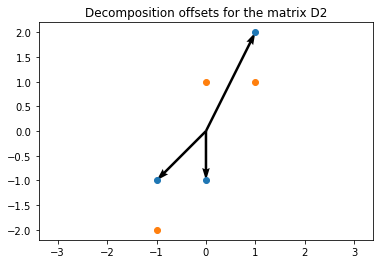

In [12]:
plt.axis('equal'); plt.title("Decomposition offsets for the matrix D2")
plt.quiver(*np.zeros(offsets.shape),*offsets,angles='xy',scale_units='xy',scale=1);
plt.scatter(*offsets); plt.scatter(*(-offsets));

### 1.2 Case of a $3 \times 3$ matrix.

As previously, we generate a 3x3 random psd tensor, decompose it and validate the absence of reconstruction error.

In [13]:
D3 = MakeRandomTensor(3)

In [14]:
coefs,offsets = Selling.Decomposition(D3)

In [15]:
sb = Selling.ObtuseSuperbase(D3)
lp.cross(sb[:,1],sb[:,2])

array([-1.,  0., -0.])

In [16]:
assert allclose(D3,Reconstruct(coefs,offsets))

In [17]:
print("Selling decomposition of matrix : \n", D3)
print("Coefficients : ", coefs)
print("Offsets : \n", offsets)

Selling decomposition of matrix : 
 [[ 0.86853982 -0.08963958 -0.06552819]
 [-0.08963958  0.50213052 -0.73715916]
 [-0.06552819 -0.73715916  2.85683026]]
Coefficients :  [0.15516777 0.08963958 0.62373247 0.23502864 1.49444606 0.1774623 ]
Offsets : 
 [[-1  1 -1  0  0  0]
 [ 0 -1  0  1  0 -1]
 [ 1  1  0 -2  1  1]]


### 1.3 Case of (extremely) strong anisotropy

Selling's tensor decomposition algorithm requires the matrix to be positive definite. It involves a loop, which number of iterations explodes as the matrix degenerates.

A maximum number of iterations is set by default, to a reasonably large value, so that non-convergence is typically due to an error on the user's side - namely a non-positive matrix. 

In [18]:
# Construct some matrix with extremely large condition number
eps = 1/200.
D2_bad = np.array([[1,eps],[eps,2*eps**2]])

In [19]:
#Selling's decomposition does not terminate within the iteration limit
try:
    coefs,offsets = Selling.Decomposition(D2_bad)
except ValueError as e:
    print(e.args)

("Selling's algorithm did not terminate in iterMax2=100 iterations",)


The iteration limit of Selling's algorithm may be increased, so as to ensure correct termination.

In [20]:
Selling.iterMax2 *= 2

In [21]:
coefs,offsets = Selling.Decomposition(D2_bad)

However, the resulting offsets are unlikely to be of use for any PDE discretization, since they are way too large. 

Note also that basis reduction techniques more efficient than Selling's algorithm are available for tensors with extremely large condition numbers. (E.g. Lagrange's algorithm.)

In [22]:
print("offsets : \n", offsets)

offsets : 
 [[-99 100  -1]
 [ -1   1   0]]


### 1.4 Decomposition a field of symmetric tensors

Our implementation of Selling's algorithm automatically threads over dimensions deeper than two.

In [23]:
# Generate a 10x10 field of random 2x2 spd tensors
D2_field = MakeRandomTensor(2,(10,10))

In [24]:
coefs, offsets = Selling.Decomposition(D2_field)

In [25]:
assert allclose(D2_field,Reconstruct(coefs,offsets))

## 2. Under the hood : obtuse superbases

This section illustrates the main mathematical concept underlying Selling's decomposition, known as *obtuse superbases* of the lattice $Z^d$.

A superbase of $Z^d$ is a special kind of coordinate system $(b_0,\cdots,b_d)$, spanning the lattice of integer points and with some redundancy. More precisely, one requires
$$
\begin{aligned}
    b_0+\cdots+b_d &= 0\\
    \det(b_1,\cdots,b_d) &= \pm 1
\end{aligned}
$$
Obtuseness is a geometrical property, related to the tensor being decomposed, and illustrated below.


### 2.1 Two dimensions

Given a positive definite tensor $D$, of dimension $d \in \{2,3\}$, Selling's algorithm produces a superbase obeying a  geometrical condition described below.

<!---ExoFR
Implémenter l'algorithme de Selling, pour construire une superbase $D$-obtuse pour toute matrice symétrique définie positive $D$ donnée de taille $2 \times 2$.

On rappelle que si $(v_0,v_1,v_2)$ est une superbase qui n'est pas obtuse, donc satisfaisant $<v_i,D v_j> > 0$ où $\{i,j,k\}$ est une permutation de $\{0,1,2\}$, alors la règle de mise à jour Selling est 
$$
    (v_0,v_1,v_2) \gets (-v_i,v_j,v_i-v_j).
$$
--->

<!---ExoCode
def ObtuseSuperbase2(D,niter=100):
    """
    Input.
     - D :  array of shape (2,2)
    Output : 
     - sb : array of shape (2,3)
    """
    sb = np.array([[-1,-1],[1,0],[0,1]]) # here of shape (3,2), transposed in the end
    for _ in range(niter):
        for i,j,k in [(0,1,2),(0,2,1),(1,2,0)]:
            # TODO : check if <sb_i, D sb_j> > 0
            # in that case, apply the Selling update rule and break
        else: 
            # All superbase angles are obtuse
            return sb.T
    raise ValueError(f"Selling algorithm failed to converge in {niter} iterations")

# Try your code
sb = ObtuseSuperbase2(D2)
--->

<!---
def ObtuseSuperbase2(D,niter=100):
    sb = np.array([[-1,-1],[1,0],[0,1]])
    for _ in range(niter):
        for i,j,k in [(0,1,2),(0,2,1),(1,2,0)]:
            if lp.dot_VAV(sb[i],D,sb[j]) > 0:
                sb[k] = sb[i]-sb[j]
                sb[i] = -sb[i]
                break
        else: 
            return sb.T
    raise ValueError(f"Selling algorithm failed to converge in {niter} iterations")
--->

In [26]:
sb = Selling.ObtuseSuperbase(D2)

In [27]:
sb

array([[-1., -1.,  2.],
       [ 1., -0., -1.]])

The generated superbase $(b_0,\cdots,b_d)$ is designed to be $D$-obtuse. In other words to obey 
$$
    <b_i,D b_j> \leq 0
$$
for all distinct $i,j\in \{0,\cdots,d\}$.

In [28]:
[lp.dot_VAV(sb[:,i],D2,sb[:,np.mod(i+1,3)]) for i in range(3)]

[-0.241545753744008, -0.4346796384446705, -0.9478743070679037]

The tensor decomposition reads 
$$
    D = -\sum_{0\leq i<j \leq d} <b_i,D b_j> v_{ij} v_{ij}^T,
$$
where one defines $v_{ij} = \pm b_k^\perp$ where $\{i,j,k\} = \{0,1,2\}$. 

In particular, 
* the weight of the decomposition are the negated scalar products.
* the offsets of the decomposition are the superbase elements rotated by $\pi/2$.

<!---ExoFR
Implémentez la formule de reconstruction de Selling, en dimension 2.
--->

<!---ExoCode
def Decomposition2(D):
    coefs = []
    offsets = []
    for i,j,k in [(0,1,2),(0,2,1),(1,2,0)]:
        coefs.append(   # TODO. Append coefficient
        offsets.append( # TODO. Append offset
    return np.array(coefs),np.array(offsets).T
--->

<!---
def Decomposition2(D):
    sb = ObtuseSuperbase2(D)
    coefs = []
    offsets = []
    for i,j,k in [(0,1,2),(0,2,1),(1,2,0)]:
        coefs.append(-lp.dot_VAV(sb[:,i],D,sb[:,j]))
        offsets.append([sb[1,k],-sb[0,k]])
    return np.array(coefs),np.array(offsets).T
--->

In [29]:
coefs,offsets = Selling.Decomposition(D2,sb=sb)

In [30]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets)

Coefficients :  [0.43467964 0.94787431 0.24154575]
Offsets : 
 [[-1  0  1]
 [-1 -1  2]]


It is possible to produce a tensor decomposition from an arbitrary superbase, but the coefficients are positive only if the superbase is obtuse.

In [31]:
sb = Selling.CanonicalSuperbase(D2) # Takes dimension an array type from argument
coefs,offsets = Selling.Decomposition(D2,sb=sb)
print("Coefficients : ", coefs)
print("Offsets : \n", offsets)

Coefficients :  [-0.91777115  3.26650811  1.59399654]
Offsets : 
 [[ 1  0 -1]
 [-1  1  0]]


### 2.2 Three dimensions

We follow similar steps in dimension $d=3$.

<!---ExoFR
Implémenter l'algorithme de Selling, pour construire une superbase $D$-obtuse pour toute matrice symétrique définie positive $D$ donnée de taille $3 \times 3$.

On rappelle que si $(v_0,v_1,v_2,v_3)$ est une superbase qui n'est pas obtuse, donc satisfaisant $<v_i,D v_j> > 0$ où $\{i,j,k,l\}$ est une permutation de $\{0,1,2,3\}$, alors la règle de mise à jour Selling est 
$$
    (v_0,v_1,v_2,v_3) \gets (-v_i,v_j,v_k+v_i,v_l+v_i).
$$
--->

<!---ExoCode
def ObtuseSuperbase3(D,niter=100):
    """
    Input.
     - D :  array of shape (3,3)
    Output : 
     - sb : array of shape (3,6)
    """
    # TODO : reprendre et adapter ObtuseSuperbase2
    raise ValueError(f"Selling algorithm failed to converge in {niter} iterations")

# Try your code
sb = ObtuseSuperbase3(D3)
--->

In [32]:
sb = Selling.ObtuseSuperbase(D3)

In [33]:
sb

array([[ 1., -0.,  0., -1.],
       [ 0.,  1.,  1., -2.],
       [ 0.,  1.,  0., -1.]])

The superbase, once updated by Selling's algorithm, is again $D$-obtuse as in two dimensions.

In [34]:
[lp.dot_VAV(sb[:,i],D3,sb[:,j]) for i in range(4) for j in range(i)]

[-0.15516776941907545,
 -0.08963958172347006,
 -0.23502863838412358,
 -0.6237324732734054,
 -1.4944460568297007,
 -0.17746229691144133]

The tensor decomposition reads 
$$
    D = -\sum_{0\leq i<j \leq d} <b_i,D b_j> v_{ij} v_{ij}^T,
$$
where one defines $v_{ij} = \pm b_k \wedge bl$ where $\{i,j,k,l\} = \{0,1,2,3\}$. 

In particular, 
* the weight of the decomposition are the negated scalar products.
* the offsets of the decomposition are the cross-products of superbase elements (or their opposites)

<!---ExoFR
Implémenter la formule de décomposition de Selling en dimension $d=3$.
--->

<!---ExoCode
def Decomposition3(D):
    """
    Input.
     - D :       array of shape (3,3)
    Output.
     - coefs :   array of shape (6,)
     - offsets : array of shape (3,6)
    """
    coefs = []
    offsets = []
    # TODO : Reprendre et adapter Decomposition2
    return np.array(coefs),np.array(offsets).T
--->

In [35]:
coefs,offsets = Selling.Decomposition(D3)

In [36]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets)

Coefficients :  [0.15516777 0.08963958 0.62373247 0.23502864 1.49444606 0.1774623 ]
Offsets : 
 [[-1  1 -1  0  0  0]
 [ 0 -1  0  1  0 -1]
 [ 1  1  0 -2  1  1]]


In [37]:
#Comparing with the cross products of the superbase elements.
ad.array(
    [lp.cross(sb[:,i],sb[:,j]) for i in range(4) for j in range(i)]
).astype(int).T

array([[ 0,  0,  1,  0, -1,  1],
       [ 1,  0,  0, -1,  1,  0],
       [-1, -1,  0,  2, -1, -1]])

## 3. Properties of the decomposition

Selling's decomposition of tensors, presented in this notebook has a qualities that make it particularly suitable for PDE discretizations. More precisely, it is:
* *Local*: The offsets appearing in the decomposition are typically small, and in any case bounded by the anisotropy ratio of the tensor, see below.
* *Stable*: The decomposition is unique, up to trivial transformations (reordering the offsets, and replacing some with their opposites). It is also stable, more precisely it is locally Lipschitz w.r.t. the decomposed tensor.  
* *Spanning* The offsets span $Z^d$ by linear relations with integer coordinates. In practice, this means that anisotropic PDE discretizations using this method should not produce chessboard artifacts. 


We illustrate these properties in dimension $d=2$, by considering a rotating family of tensors with fixed condition number. For any positive definite tensor $D$ we let 
$$
    \mu(D) := \sqrt{\|D\| \|D^{-1}\|}
$$ 
denote the anisotropy ratio, i.e. the sqrt of the condition number of $D$.

In [38]:
theta = np.linspace(0,np.pi/2,100)
mu = 10
D2_rotating = (
    mu**2 * lp.outer_self(np.array([np.cos(theta),np.sin(theta)])) 
    + lp.outer_self(np.array([-np.sin(theta),np.cos(theta)])) 
)

In [39]:
coefs,offsets = Selling.Decomposition(D2_rotating)

### 3.1 Offsets smallness 

The offsets $(e_i)_{1 \leq i \leq I}$ involved in Selling's decomposition of a tensor $D$ obey
$$
    \|e_i\| \leq C \mu(D),
$$
where $C$ is an absolute constant. 

In [40]:
offsets_norms = np.sqrt(np.sum(offsets**2,axis=0))

In [41]:
print("Sqrt of condition number : ", mu)
print("Largest offset norm : ", np.max(offsets_norms))

Sqrt of condition number :  10
Largest offset norm :  5.0990195135927845


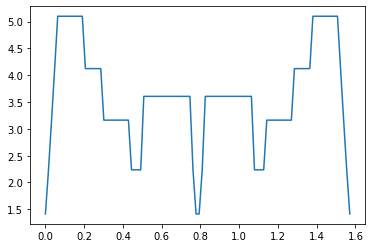

In [42]:
plt.plot(theta,np.max(offsets_norms,axis=0));

### 3.2 Stability

We may rewrite Selling's decomposition in an indexation independent manner, as follows
$$
    D = \sum_{e \in Z^d} \lambda^e(D) e e^T.
$$
One can the prove that the coefficient $\lambda^e(D)$ of Selling's tensor decomposition, for a given offset $e \in Z^d$, depends continuously on the parameter $D$, as illustrated below. 

In [43]:
decomp = Selling.GatherByOffset(theta,coefs,offsets)

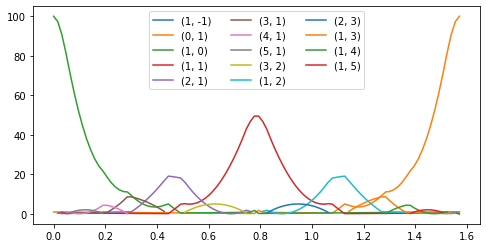

In [44]:
fig = plt.figure(figsize=(8,4))
for offset,(angle,coef) in decomp.items():
    plt.plot(angle,coef)
plt.legend(decomp.keys(),ncol=3);
savefig(fig,"Coefs_Sel2_rot.pdf")

### 3.3 Spanning property (no chessboard artifacts)

The lattice $Z^d$ is spanned, by integer combinations, by the offsets $(e_i)_{1 \leq i \leq I}$ appearing in the decomposition of an arbitrary p.s.d. tensor $D$. In other words, for all $x \in Z^d$, there exists coefficisnts $k_1,\cdots, k_I \in Z$ such that 
$$
    x = k_1 e_1 + \cdots+ k_d e_d.
$$
In addition, one may select this decomposition so that the weight $\lambda_i$ of $e_i$ is positive whenever $k_i \neq 0$.

This property guarantees that the graph underlying e.g. the discretization of an anisotropic laplacian is locally connected, hence that spurious modes such as chessboard artifacts will not appear. 

From a mathematical standpoint, the spanning property can be deduced from the construction of the decomposition in terms of obtuse superbases. Numerically, we can check it by finding a subset of the offsets whose determinant equals $\pm 1$. 

In [45]:
lp.det(offsets[:,0:2])

array([ 1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1])

In [46]:
coefs,offsets = Selling.Decomposition(D3)

In [47]:
lp.det(offsets[:,0:3])

-1

### 3.4 Piecewise linearity

The Selling's coefficients depend in a piecewise linear manner on the decomposed tensor. This property can be exploited, in (often quite sophisticated) numerical schemes.

In [48]:
np.random.seed(42)

In [49]:
def Interpolate(a,b,T=np.linspace(0,1,100)):
    return T, np.moveaxis(ad.array([(1-t)*a + t*b for t in T]),0,-1)

In [50]:
t,D2t = Interpolate(MakeRandomTensor(2),MakeRandomTensor(2))
decomp = Selling.GatherByOffset(t,*Selling.Decomposition(D2t))

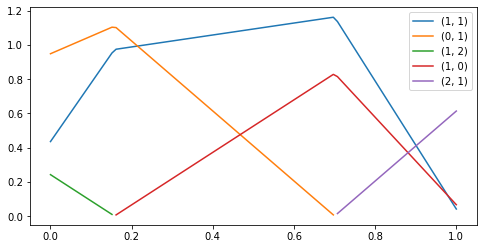

In [51]:
fig = plt.figure(figsize=(8,4))
for offset,(time,coef) in decomp.items(): plt.plot(time,coef)
plt.legend(decomp.keys())
savefig(fig,"Coefs_Sel2.pdf")

In [52]:
t,D3t = Interpolate(MakeRandomTensor(3),MakeRandomTensor(3))
decomp = Selling.GatherByOffset(t,*Selling.Decomposition(D3t))

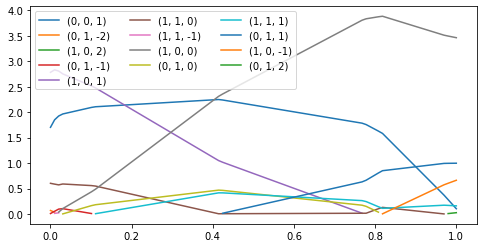

In [53]:
fig = plt.figure(figsize=(8,4))
for offset,(time,coef) in decomp.items(): plt.plot(time,coef)
plt.legend(decomp.keys(),ncol=3)
savefig(fig,"Coefs_Sel3.pdf")